In [11]:
!git clone https://github.com/rcuocolo/PROSTATEx_masks

Cloning into 'PROSTATEx_masks'...
remote: Enumerating objects: 5026, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 5026 (delta 353), reused 195 (delta 179), pack-reused 4650
Receiving objects: 100% (5026/5026), 902.72 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (3701/3701), done.
Updating files: 100% (2565/2565), done.


# Load Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#for colab
%cd "/content/drive/MyDrive/Prostate_Lesion/"

/content/drive/MyDrive/Prostate_Lesion


In [3]:
%pip install -r requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.9 MB/s eta 0:00:00


# initiate

In [4]:
import pandas as pd
import nibabel as nib
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
import pandas as pd


import json
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os

from monai.utils import first

In [5]:
HOME_DIR =       "./"
DATA_DIR =       "./PROSTATEx_masks/Files/lesions/"
OUT_DIR =        "./results/lesion/"
SLICED_OUT_DIR = "./data/sliced/"
AUG_OUT_DIR = "./data/augmented/"

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Prostate_Lesion/PROSTATEx_masks/Files/lesions/Image_list.csv')

In [8]:
import os
if not os.path.exists(SLICED_OUT_DIR + "images/"):
    os.makedirs(SLICED_OUT_DIR + "images/")
if not os.path.exists(SLICED_OUT_DIR + "prostates/"):
    os.makedirs(SLICED_OUT_DIR + "prostates/")
if not os.path.exists(SLICED_OUT_DIR + "pz_masks/"):
    os.makedirs(SLICED_OUT_DIR + "pz_masks/")
if not os.path.exists(SLICED_OUT_DIR + "tz_masks/"):
    os.makedirs(SLICED_OUT_DIR + "tz_masks/")
if not os.path.exists(SLICED_OUT_DIR + "labels/"):
    os.makedirs(SLICED_OUT_DIR + "labels/")

In [ ]:
data = []
for index, row in df.iterrows():
    value = row['T2'].split("-")
    numb= value[1].split("_")[0]
    if int(numb) == 128:
        t2 = DATA_DIR+'Images/T2/'+row['T2']+'.nii'
    else:
        t2 = DATA_DIR+'Images/T2/'+row['T2']+'.nii.gz'
    if int(numb) == 25:
        adc = DATA_DIR+'Images/ADC/'+row['ADC']+'a.nii.gz'
    elif int(numb) == 113:
        value = row['ADC'][:-2]+'9'
        adc = DATA_DIR+'Images/ADC/'+value+'.nii.gz'
    elif int(numb) == 203:
        adc = DATA_DIR+'Images/ADC/'+'ProstateX-0203_diffusie-3ProstateX-0203_diffusie-3Scan-4bval_fs_7.niiScan-4bval_fs_7.nii.gz'
    else:
        adc = DATA_DIR+'Images/ADC/'+row['ADC']+'.nii.gz'
   
    data.append({ 'T2': t2, 'ADC': adc , 'name': value[0] + '_' +str(numb)})

In [ ]:
import nibabel as nib
import json
import numpy as np

def load_nifti(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = nib.load(image_nifty_file)
    label = nib.load(label_nifty_file)
    
    return image, label

def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)


def remove_slices(img,start, end):
  imgvol = np.array( img.dataobj )
  imgvol = imgvol[ :, :, start:end ]
  newimg = nib.Nifti1Image ( imgvol, img.affine )
  return newimg



In [ ]:
# to load chech T2 and adc
def create_same_slice_nifti(data, slice_size ):
  paths = []
  total = len(data)
  count = 1
  for entry in data:
    img, lbl = load_nifti(entry["T2"], entry["ADC"])

    if img.shape[2] != lbl.shape[2]:
      print("images of different sizes", img.shape, lbl.shape)

  #   total_slize_size =img.shape[2]
  #   if(total_slize_size < slice_size): print("ERROR: slice upper limit exceeds")
  #   extra_slices = total_slize_size - slice_size
  #   end  = total_slize_size - (extra_slices // 2 )
  #   start = end - slice_size 

  #   newimg = remove_slices(img,start, end)
  #   newlbl = remove_slices(lbl,start, end)
  #   image_path = entry["image"].replace('PROSTATEx_masks/Files', "data/sliced")
  #   label_path = entry["label"].replace('PROSTATEx_masks/Files', "data/sliced")
  #   paths.append({"image":image_path, "label":label_path})
  #   newimg.to_filename(image_path );
  #   newlbl.to_filename(label_path);
    
  #   print(f"{count}/{total}")
  #   count += 1

  # save_to_json({"path": paths}, dir + 'config.json')

slice_size = 16
create_same_slice_nifti(data, slice_size )



In [ ]:
df = pd.read_csv(DATA_DIR +'image_list.csv')

FileNotFoundError: ignored

In [ ]:
import os
import nibabel as nib

# specify the directory path
image_path = './PROSTATEx_masks/Files/prostate/Images/'
prostate_path = './PROSTATEx_masks/Files/prostate/mask_prostate/'
pz_path = './PROSTATEx_masks/Files/prostate/mask_pz/'
tz_path = './PROSTATEx_masks/Files/prostate/mask_tz/'
lesion_path = './PROSTATEx_masks/Files/lesions/Masks/T2/'
#t2_path = './PROSTATEx_masks/Files/lesions/Images/T2/'
#adc_path = './PROSTATEx_masks/Files/lesions/Masks/ADC/'

# get all the file names in the directory
t2_images = os.listdir(image_path)
prostates = os.listdir(prostate_path)
pz_images = os.listdir(pz_path)
tz_images = os.listdir(tz_path)
t2_lesions = os.listdir(lesion_path)
#t2_2 = os.listdir(t2_path)
#adc_images = os.listdir(adc_path)

data = []
for i in range(len(df['T2'])):
    t2 = nib.load(image_path + t2_images[i])
    prostate = nib.load(prostate_path + prostates[i])
    pz = nib.load(pz_path + pz_images[i])
    tz = nib.load(tz_path + tz_images[i])
    lesion = nib.load(lesion_path + t2_lesions[i])
    name = t2_images[i].split('_')[0]

    
    if t2.shape[2] == lesion.shape[2]:
        path = {
            'T2': image_path + t2_images[i],
            'prostate': prostate_path + prostates[i],
            'PZ' : pz_path + pz_images[i],
            'TZ': tz_path + tz_images[i],
            'label': lesion_path + t2_lesions[i],
            'Name':name
        }
        data.append(path)





In [ ]:
import nibabel as nib
import json
import numpy as np

def load_nifti(image_path_1,image_path_2,image_path_3,image_path_4, label_path):
    # load the image and label file, get the image content and return a numpy array for each
    image1 = nib.load(image_path_1)
    image2 = nib.load(image_path_2)
    image3 = nib.load(image_path_3)
    image4 = nib.load(image_path_4)
    label = nib.load(label_path)
    
    return image1,image2,image3,image4, label

def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)


def remove_slice(img,  slice_size):
    total_slize_size = img.shape[2]
    extra_slices = total_slize_size - slice_size
    end  = total_slize_size - (extra_slices // 2 )
    start = end - slice_size 
    imgvol = np.array( img.dataobj )
    imgvol = imgvol[ :, :, start:end ]
    newimg = nib.Nifti1Image ( imgvol, img.affine )
    return newimg

def create_same_slice_nifti(data, slice_size ,dir):
  paths = []
  total = len(data)
  count = 1
  for entry in data:
    image, prostate, pz , tz, label = load_nifti(entry["T2"], entry["prostate"], entry["PZ"], entry["TZ"], entry["label"])

    total_slize_size = min( image.shape[2], prostate.shape[2], pz.shape[2] , tz.shape[2], label.shape[2])
    if(total_slize_size < slice_size): 
      print("ERROR: slice upper limit exceeds")
      continue
    

    new_image = remove_slice(image,slice_size)
    new_prostate = remove_slice(prostate,slice_size)
    new_pz = remove_slice(pz,slice_size)
    new_tz = remove_slice(tz,slice_size)
    new_lbl = remove_slice(label,slice_size)

    image_path = dir + 'images/'+ entry['Name']+'.nii.gz'
    label_path = dir + 'labels/' + entry['Name']+'.nii.gz'
    prostate_path = dir + 'prostates/' + entry['Name']+'.nii.gz'
    pz_path = dir + 'pz_masks/' + entry['Name']+'.nii.gz'
    tz_path = dir + 'tz_masks/' + entry['Name']+'.nii.gz'
    
    paths.append({
      "image":image_path, 
      'prostate':prostate_path,
      'PZ': pz_path,
      'TZ' : tz_path,
      "label":label_path, 
    })
    new_image.to_filename(image_path)
    new_prostate.to_filename(prostate_path)
    new_pz.to_filename(pz_path)
    new_tz.to_filename(tz_path)
    new_lbl.to_filename(label_path)
    
    print(f"{count}/{total}")
    count += 1

  save_to_json({"path": paths}, dir + 'config.json')





In [ ]:
slice_size = 16
create_same_slice_nifti(data, slice_size ,SLICED_OUT_DIR)

1/75
2/75
3/75
4/75
5/75
6/75
7/75
8/75
9/75
10/75
11/75
12/75
13/75
14/75
15/75
16/75
17/75
18/75
19/75
20/75
21/75
22/75
23/75
24/75
25/75
26/75
27/75
28/75
29/75
30/75
31/75
32/75
33/75
34/75
35/75
36/75
37/75
38/75
39/75
40/75
41/75
42/75
43/75
44/75
45/75
46/75
47/75
48/75
49/75
50/75
51/75
52/75
53/75
54/75
55/75
56/75
57/75
58/75
59/75
60/75
61/75
62/75
63/75
64/75
65/75
66/75
67/75
68/75
69/75
70/75
71/75
72/75
73/75
74/75
75/75


# Augmentation

In [ ]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [ ]:
data = get_data_path(SLICED_OUT_DIR)

In [ ]:
import nibabel as nib
import random
import elasticdeform 
import numpy as np
import nibabel as nib

from scipy.ndimage import affine_transform, rotate, zoom
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.util import random_noise

In [ ]:
def random_flip_rotate_zoom_translate(image,PZ, TZ, Prostate, label):
    angle = random.uniform(-5, 5)
    flip_axes = [ i for i in range(2) if i!=2 and np.random.choice([0, 1]) == 1]
    translate = (random.uniform(-10,10), random.uniform(-10,10))
    matrix = np.array([[1, 0, 0, translate[0]], [0, 1, 0, translate[1]], [0, 0, 1,  0], [0, 0, 0, 1]])

    imgvol = np.array(image.dataobj)
    lblvol = np.array(label.dataobj)
    pzvol = np.array(PZ.dataobj)
    tzvol = np.array(TZ.dataobj)
    prostatevol = np.array(Prostate.dataobj)

    # Rotate
    img = rotate(imgvol, angle, reshape=False)
    lbl = rotate(lblvol, angle, reshape=False)
    pz = rotate(pzvol, angle, reshape=False)
    tz = rotate(tzvol, angle, reshape=False)
    prostate = rotate(prostatevol, angle, reshape=False)

    # Randomly flip the image and label along one or more axes, except for the z-axis
    img = np.flip(img, axis=flip_axes)
    lbl = np.flip(lbl, axis=flip_axes)
    pz = np.flip(pz, axis=flip_axes)
    tz = np.flip(tz, axis=flip_axes)
    prostate = np.flip(prostate, axis=flip_axes)
    

    # zoom
    zoom_factor = random.uniform(0.8, 1.2)
    img = zoom(img, zoom_factor, order=1)
    pz = zoom( pz, zoom_factor, order=0)
    tz = zoom(tz, zoom_factor, order=0)
    prostate = zoom(prostate, zoom_factor, order=0)
    lbl = zoom(lbl, zoom_factor, order=0)

    # Translate
    img = affine_transform(img, matrix, order=1)
    pz = affine_transform(pz, matrix, order=0)
    tz = affine_transform(tz, matrix, order=0)
    prostate = affine_transform(prostate, matrix, order=0)
    lbl = affine_transform(lbl, matrix, order=0)

    image = nib.Nifti1Image(img, image.affine)
    pz = nib.Nifti1Image(pz, PZ.affine)
    tz = nib.Nifti1Image(tz, TZ.affine)
    prostate = nib.Nifti1Image(prostate, Prostate.affine)
    label = nib.Nifti1Image(lbl, label.affine)
    return image, pz, tz, prostate, label

In [ ]:
def load_nifti(image_path_1,image_path_2,image_path_3,image_path_4, label_path):
    # load the image and label file, get the image content and return a numpy array for each
    image1 = nib.load(image_path_1)
    image2 = nib.load(image_path_2)
    image3 = nib.load(image_path_3)
    image4 = nib.load(image_path_4)
    label = nib.load(label_path)
    
    return image1,image2,image3,image4, label

In [ ]:
def save_to_json(data, path):
  with open(path, 'w') as fp:
    json.dump(data, fp)

In [ ]:
import os
times = ['fold1','fold2', 'fold3']
for fold in times:
    if not os.path.exists(AUG_OUT_DIR + fold + "/images/"):
        os.makedirs(AUG_OUT_DIR + fold + "/images/")
    if not os.path.exists(AUG_OUT_DIR + fold + "/prostates/"):
        os.makedirs(AUG_OUT_DIR + fold + "/prostates/")
    if not os.path.exists(AUG_OUT_DIR + fold + "/pz_masks/"):
        os.makedirs(AUG_OUT_DIR + fold + "/pz_masks/")
    if not os.path.exists(AUG_OUT_DIR + fold + "/tz_masks/"):
        os.makedirs(AUG_OUT_DIR + fold + "/tz_masks/")
    if not os.path.exists(AUG_OUT_DIR + fold + "/labels/"):
        os.makedirs(AUG_OUT_DIR + fold + "/labels/")

In [ ]:
paths = []
dir = AUG_OUT_DIR
times = ['fold1','fold2', 'fold3']
for fold in times:
  for entry in data:
      image, Prostate, PZ , TZ, label = load_nifti(entry["image"], entry["prostate"], entry["PZ"], entry["TZ"], entry["label"])
      
      image, pz, tz, prostate, label = random_flip_rotate_zoom_translate(image,PZ, TZ, Prostate, label)

      image_path = entry["image"].replace("data/sliced", "data/augmented/" + fold)
      label_path = entry["label"].replace("data/sliced", "data/augmented/" + fold)
      prostate_path = entry["prostate"].replace("data/sliced", "data/augmented/" + fold)
      pz_path = entry["PZ"].replace("data/sliced", "data/augmented/" + fold)
      tz_path = entry["TZ"].replace("data/sliced", "data/augmented/" + fold)
      

      image.to_filename(image_path)
      prostate.to_filename(prostate_path)
      pz.to_filename(pz_path)
      tz.to_filename(tz_path)
      label.to_filename(label_path)

      paths.append({
        "image":image_path, 
        'prostate':prostate_path,
        'PZ': pz_path,
        'TZ' : tz_path,
        "label":label_path, 
      })

      

save_to_json({"path": paths}, AUG_OUT_DIR + 'config.json')   

(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384, 16) (384, 384, 16)
(384, 384, 16) (384, 384, 16) (384, 384,

# Transform

In [ ]:
def get_data_path(path):
  f = open( path + 'config.json')
  jdata = json.load(f)
  f.close()
  return jdata["path"]

In [ ]:
data = get_data_path(SLICED_OUT_DIR)
aug_data = get_data_path(AUG_OUT_DIR)
print(len(data))

train_size = int(0.8 * len(data))
aug_train_size = int(0.8 * len(aug_data))
train_data =  data[:train_size] + aug_data[:aug_train_size]
test_data = data[train_size:] + aug_data[aug_train_size:]

75


In [ ]:
len(train_data)

240

In [ ]:
pixdim =(1.5, 1.5, 1.0)
a_min=0
a_max=500
spatial_size= [128, 128,16] #[384, 384,18]


In [ ]:
import numpy as np
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    SqueezeDimd
)
from monai.data import DataLoader, Dataset


class ConcatImagesd:
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, data):
        concat = np.concatenate([np.expand_dims(data[key], axis=0) for key in self.keys], axis=1)
        data[self.keys[0]] = concat
        for key in self.keys[1:]:
            del data[key]
        return data


def transform(data, a_min, a_max, spatial_size, pixdim):
    train_transforms = Compose([
        LoadImaged(keys=["image", "PZ", "TZ", "prostate", "label"], reader="ITKReader"),
        AddChanneld(keys=["label"]),
        AddChanneld(keys=["image", "PZ", "TZ", "prostate"]),
        Orientationd(keys=["image", "PZ", "TZ", "prostate", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "PZ", "TZ", "prostate", "label"], source_key="image"),
        Resized(keys=["image", "PZ", "TZ", "prostate", "label"], spatial_size=spatial_size),
        ConcatImagesd(keys=["image", "PZ", "TZ", "prostate"]),
        ToTensord(keys=["image", "label"]),
        SqueezeDimd(keys=["image"]),
    ])

    ds = Dataset(data=data, transform=train_transforms)
    loader = DataLoader(ds, batch_size=1)

    return loader


In [ ]:
#from utils.transform import transform

train_loader = transform(train_data, a_min, a_max, spatial_size, pixdim)
test_loader = transform(test_data, a_min, a_max, spatial_size, pixdim)

c:\Users\envy\Desktop\Prostate_MRI\Prostate_Lesion\packages\lib\site-packages\monai\transforms\io\array.py:199: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(
c:\Users\envy\Desktop\Prostate_MRI\Prostate_Lesion\packages\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


## Check

In [ ]:
# first image, label from orignal image
imagea =nib.load(data[0]["image"]).get_fdata()
labela =nib.load(data[0]["label"]).get_fdata()
print(imagea.shape,labela.shape)

In [ ]:
# first image, label from preprossed image
image1= first(train_loader)["image"]
label1 = first(train_loader)["label"]
print(image1.shape,label1.shape)
image11 =image1.get_array()
label11 = label1.get_array()

torch.Size([1, 4, 128, 128, 16]) torch.Size([1, 1, 128, 128, 16])


In [ ]:
# Define a function to visualize the data
def explore_3dimage2(layer):
    plt.figure(figsize=(10, 5))
    channel = 2
    # plt.imshow(image11[0,0,:,:,layer], cmap='gray');
    # plt.title('Explore Layers of Prostate MRI', fontsize=20)
    # plt.axis('off')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    ax[0].imshow(image1[0,0,:,:,layer], cmap='gray')
    ax[0].set_title(f"Image", fontsize=15)
    ax[0].axis('off')

    ax[1].imshow(label1[0,0,:,:,layer])
    ax[1].axis('off')
    return 

In [ ]:
# Explore the preprocessed image, label
interact(explore_3dimage2, layer=(0, 15))

interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage2(layer)>

# Train

In [ ]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
from utils.train import train

In [ ]:
model_dir = OUT_DIR 
data_in = [train_loader, test_loader]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

unet = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=1,
    channels=( 64, 128, 256,512), 
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True)

In [ ]:
model_dir = OUT_DIR + "unet/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
import os.path

path = OUT_DIR+ "unet/"+ "best_metric_model.pth"

if (os.path.exists(path)):
    unet.load_state_dict(torch.load(
        os.path.join(path)))

In [ ]:
train(unet, data_in, loss_function, optimizer, 10, model_dir, test_interval=2,start_from=1)

----------
epoch 1/10


/usr/local/lib/python3.9/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/239, Train_loss: 0.9985 Train_dice: 0.0015
2/239, Train_loss: 0.9972 Train_dice: 0.0028
3/239, Train_loss: 0.9964 Train_dice: 0.0036
4/239, Train_loss: 0.9967 Train_dice: 0.0033
5/239, Train_loss: 0.9910 Train_dice: 0.0090
6/239, Train_loss: 0.9935 Train_dice: 0.0065
7/239, Train_loss: 0.9743 Train_dice: 0.0257
8/239, Train_loss: 0.9981 Train_dice: 0.0019
9/239, Train_loss: 0.9989 Train_dice: 0.0011
10/239, Train_loss: 0.9882 Train_dice: 0.0118
11/239, Train_loss: 0.9904 Train_dice: 0.0096
12/239, Train_loss: 0.9947 Train_dice: 0.0053
13/239, Train_loss: 0.9958 Train_dice: 0.0042
14/239, Train_loss: 0.9910 Train_dice: 0.0090
15/239, Train_loss: 0.9928 Train_dice: 0.0072
16/239, Train_loss: 0.9956 Train_dice: 0.0044
17/239, Train_loss: 0.9895 Train_dice: 0.0105
18/239, Train_loss: 0.9982 Train_dice: 0.0018
19/239, Train_loss: 0.9920 Train_dice: 0.0080
20/239, Train_loss: 0.9629 Train_dice: 0.0371
21/239, Train_loss: 0.9971 Train_dice: 0.0029
22/239, Train_loss: 0.9971 Train_dice: 0.00

In [ ]:
from Models.ModifiedNet import MNet

mnet = MNet()

In [ ]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(unet.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True)

In [ ]:
train(unet, data_in, loss_function, optimizer, 10, model_dir, test_interval=2,start_from=1)

----------
epoch 1/10


c:\Users\envy\Desktop\Prostate_MRI\Prostate_Lesion\packages\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/240, Train_loss: 0.9959 Train_dice: 0.0041
2/240, Train_loss: 0.9941 Train_dice: 0.0059
3/240, Train_loss: 0.9932 Train_dice: 0.0068
4/240, Train_loss: 0.9604 Train_dice: 0.0396
5/240, Train_loss: 0.9903 Train_dice: 0.0097
6/240, Train_loss: 0.9964 Train_dice: 0.0036
7/240, Train_loss: 0.9897 Train_dice: 0.0103
8/240, Train_loss: 0.9606 Train_dice: 0.0394
9/240, Train_loss: 0.9960 Train_dice: 0.0040
10/240, Train_loss: 0.9820 Train_dice: 0.0180
11/240, Train_loss: 0.9688 Train_dice: 0.0312
12/240, Train_loss: 0.9955 Train_dice: 0.0045
13/240, Train_loss: 0.9969 Train_dice: 0.0031
14/240, Train_loss: 0.9942 Train_dice: 0.0058
15/240, Train_loss: 0.9910 Train_dice: 0.0090
16/240, Train_loss: 0.9878 Train_dice: 0.0122
17/240, Train_loss: 0.9769 Train_dice: 0.0231
18/240, Train_loss: 0.9955 Train_dice: 0.0045
19/240, Train_loss: 0.9972 Train_dice: 0.0028
20/240, Train_loss: 0.9917 Train_dice: 0.0083
21/240, Train_loss: 0.9750 Train_dice: 0.0250
22/240, Train_loss: 0.9909 Train_dice: 0.00

KeyboardInterrupt: 

# Plot

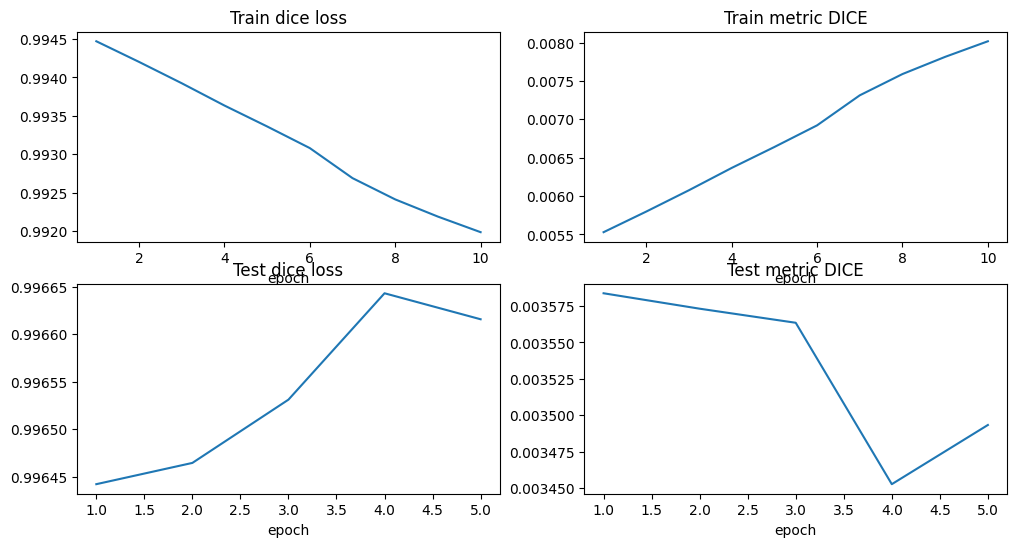

In [ ]:
from utils.view import  plt_metrices

path = OUT_DIR
if (os.path.exists(path)):
    plt_metrices(path)

In [ ]:
from monai.utils import first
from monai.transforms import(
    Activations,
)

import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=1,
    channels=( 64, 128, 256,512), 
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
import os.path

path = OUT_DIR+'unet/'+  "best_metric_model.pth"

if (os.path.exists(path)):
    model.load_state_dict(torch.load(
        os.path.join(path)))
# model.eval()

In [ ]:
spatial_size = [128,128,16]

torch.Size([1, 4, 128, 128, 16])


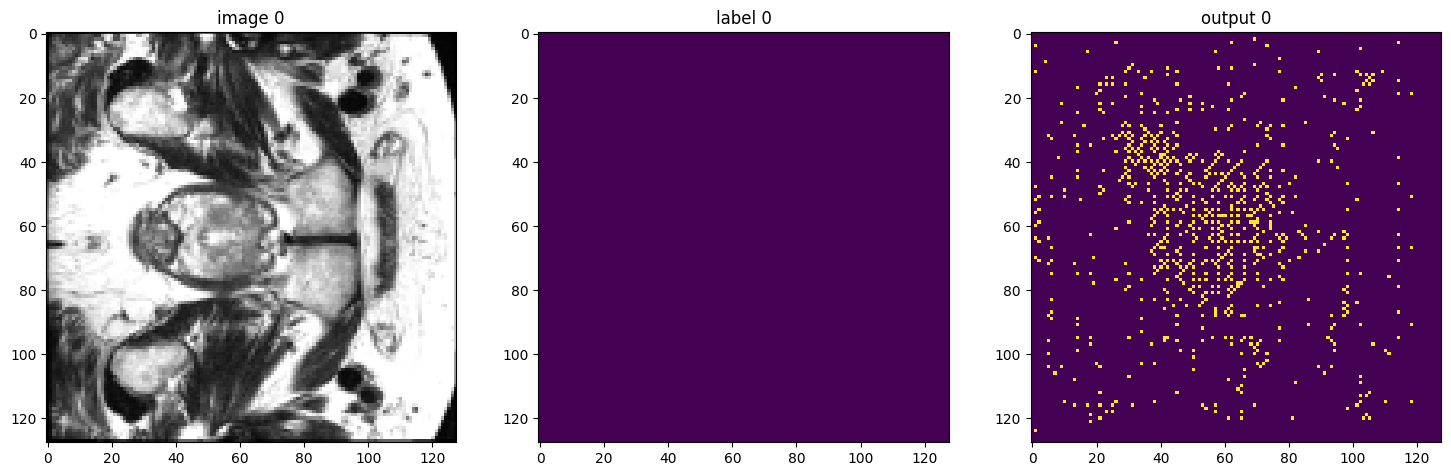

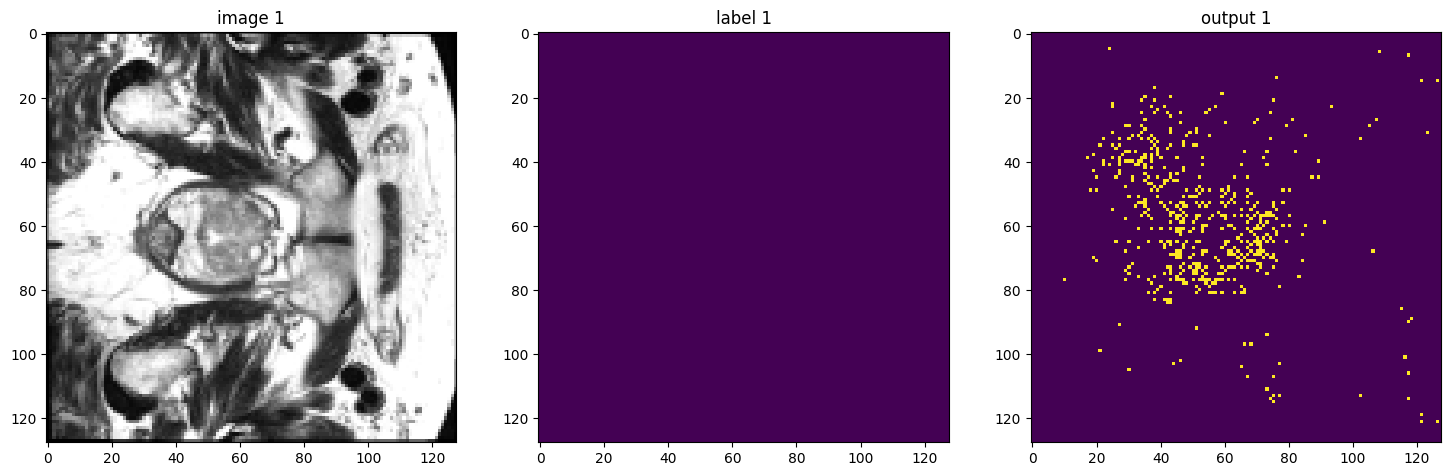

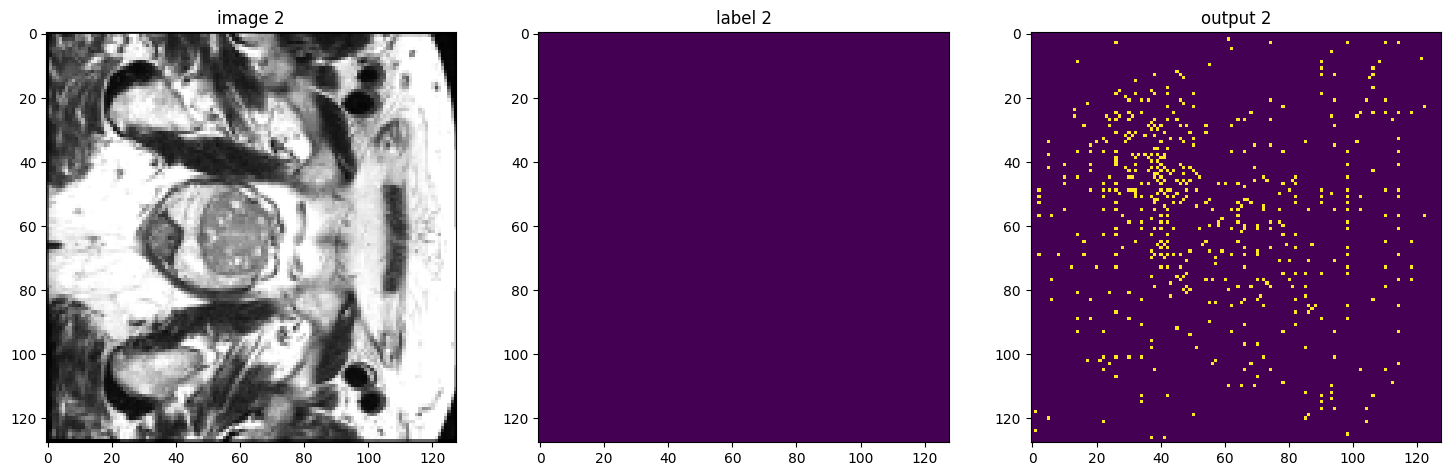

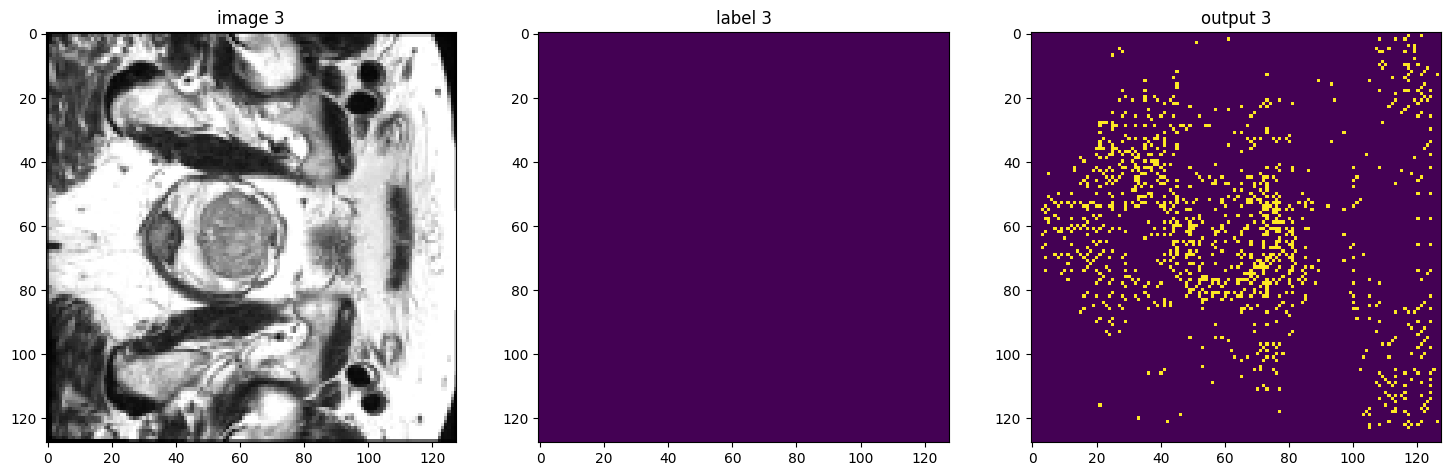

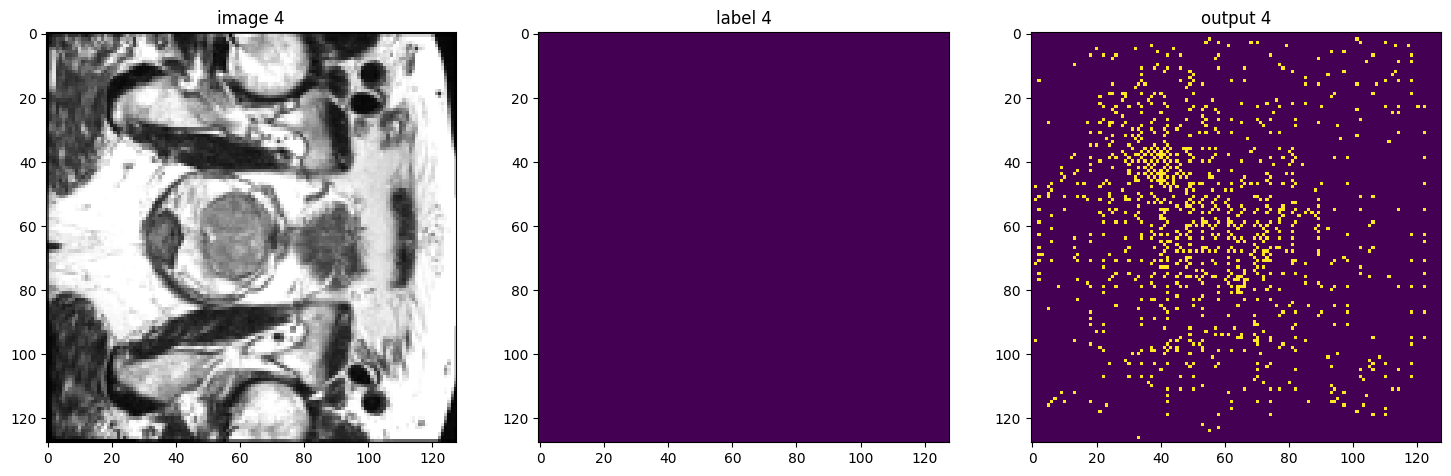

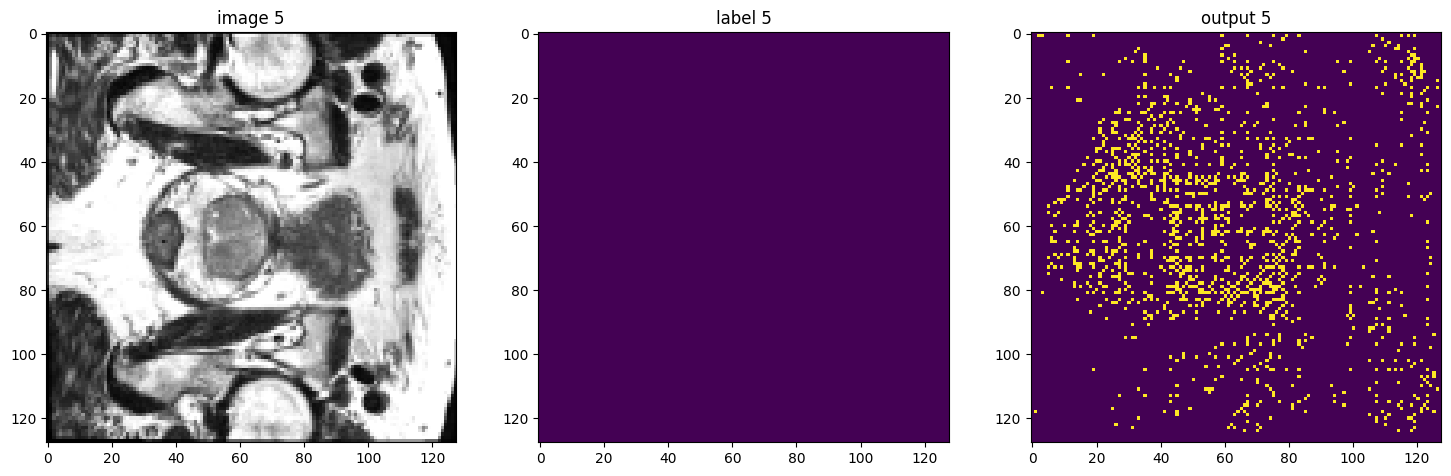

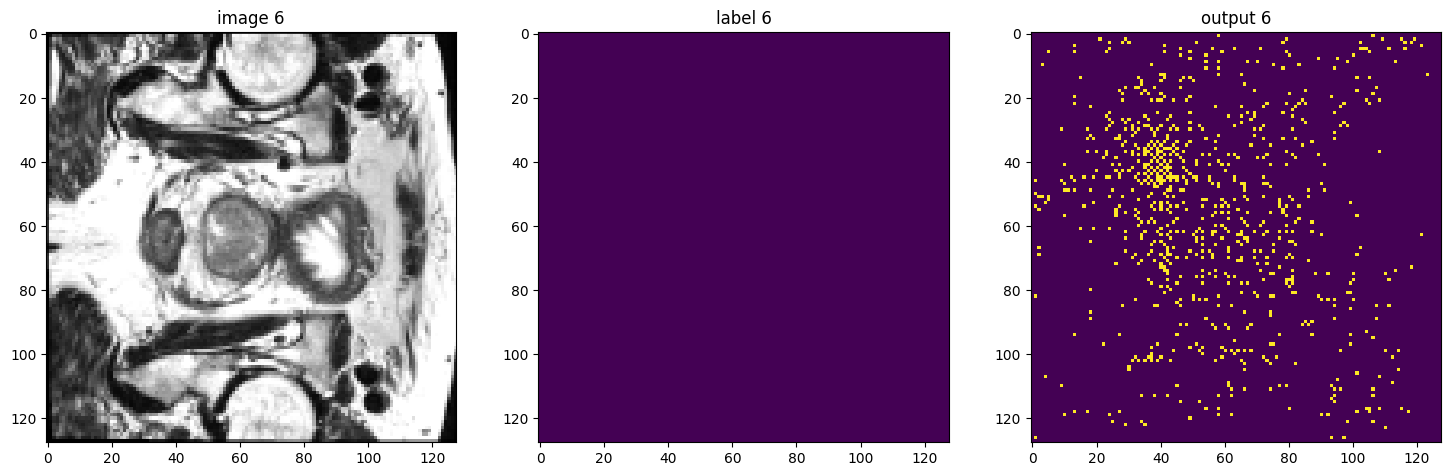

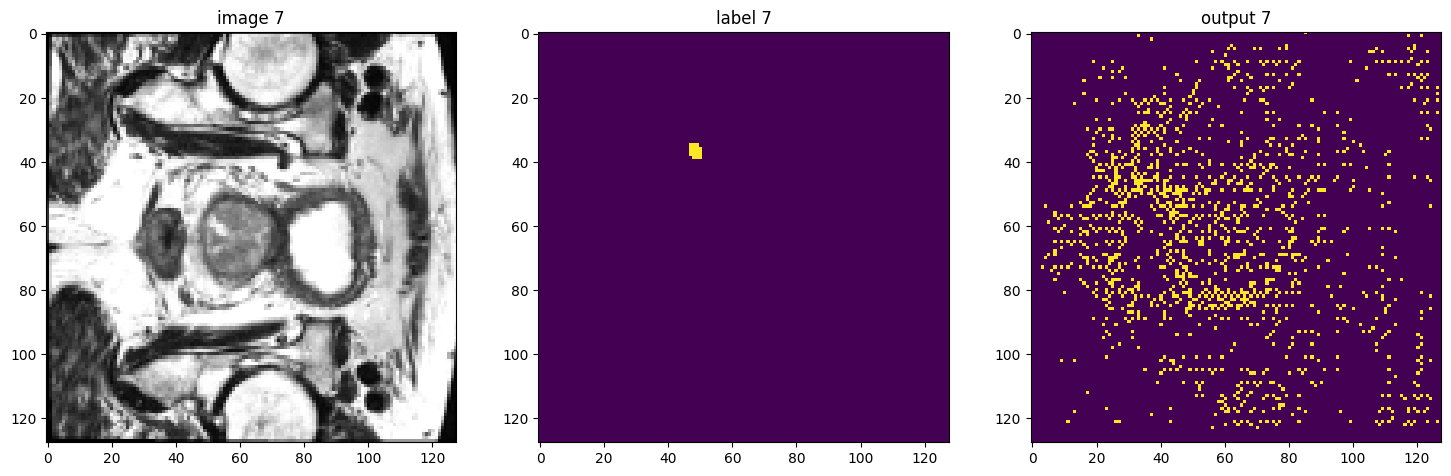

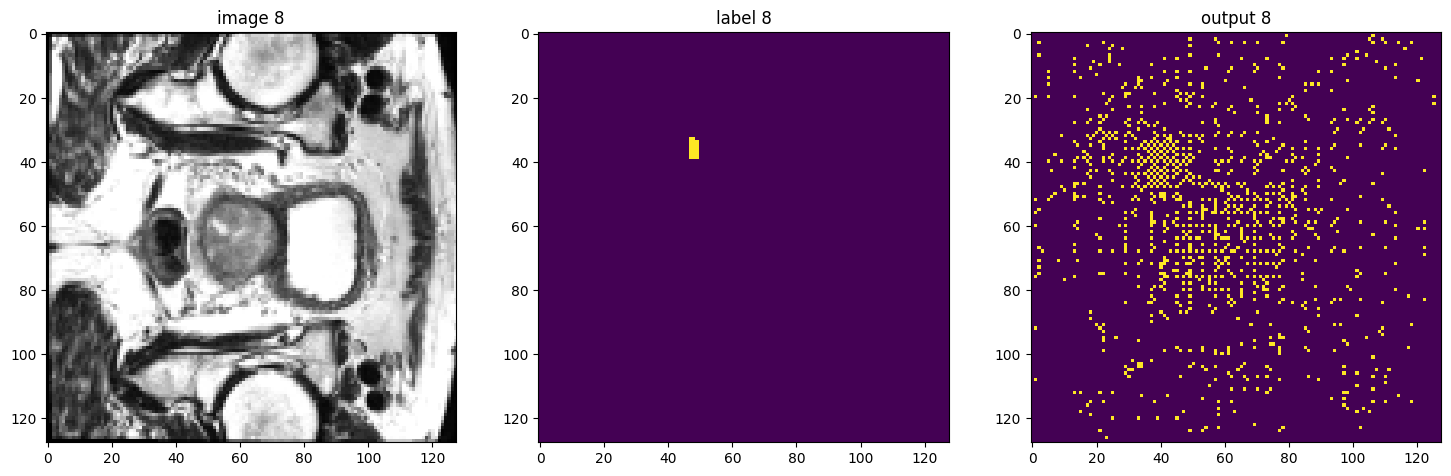

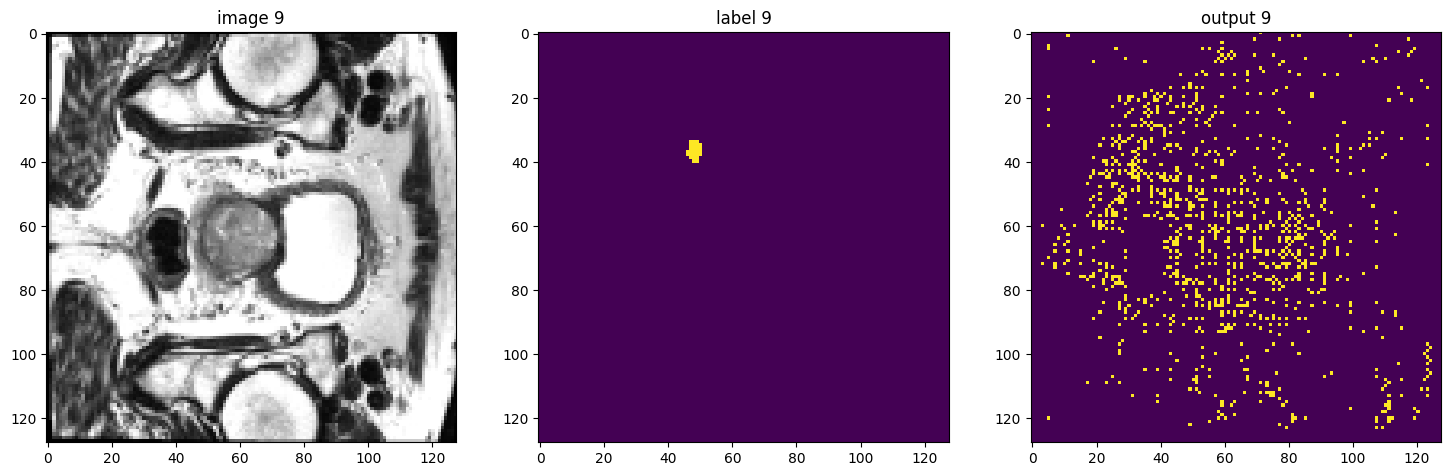

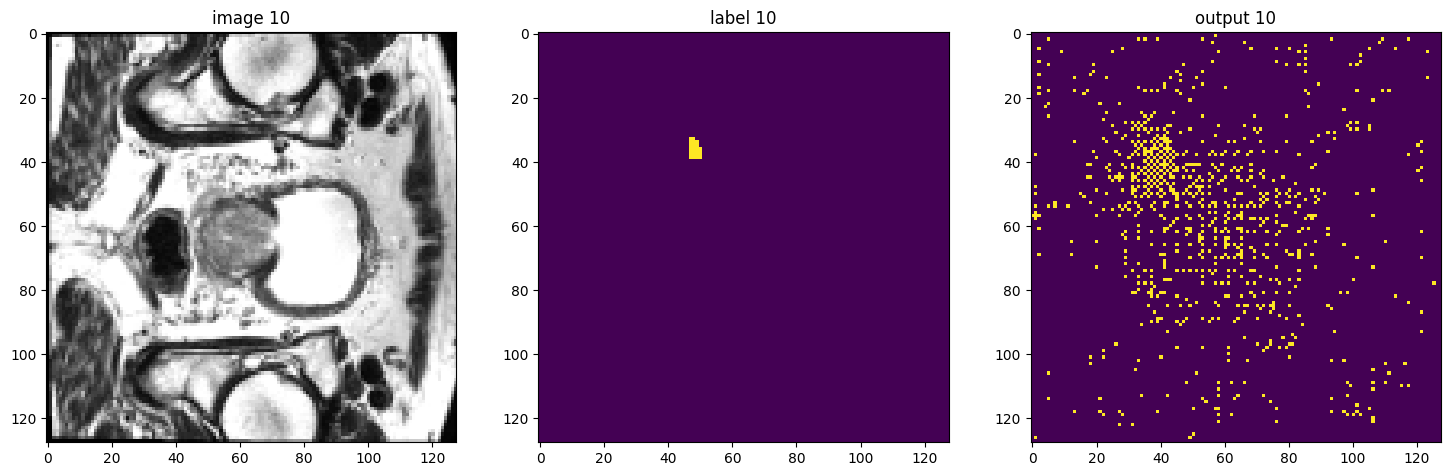

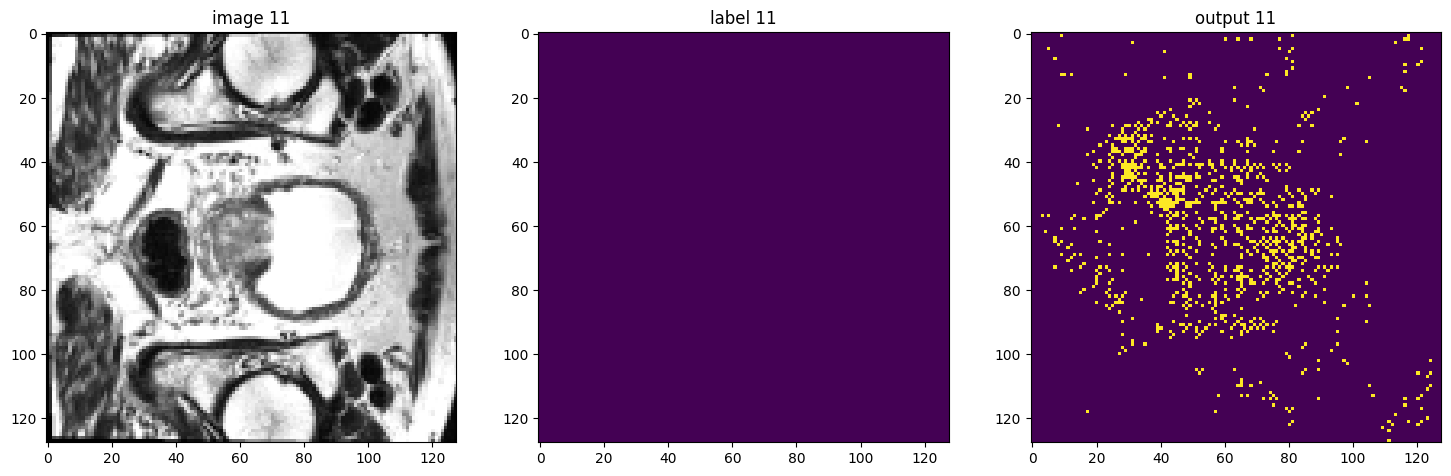

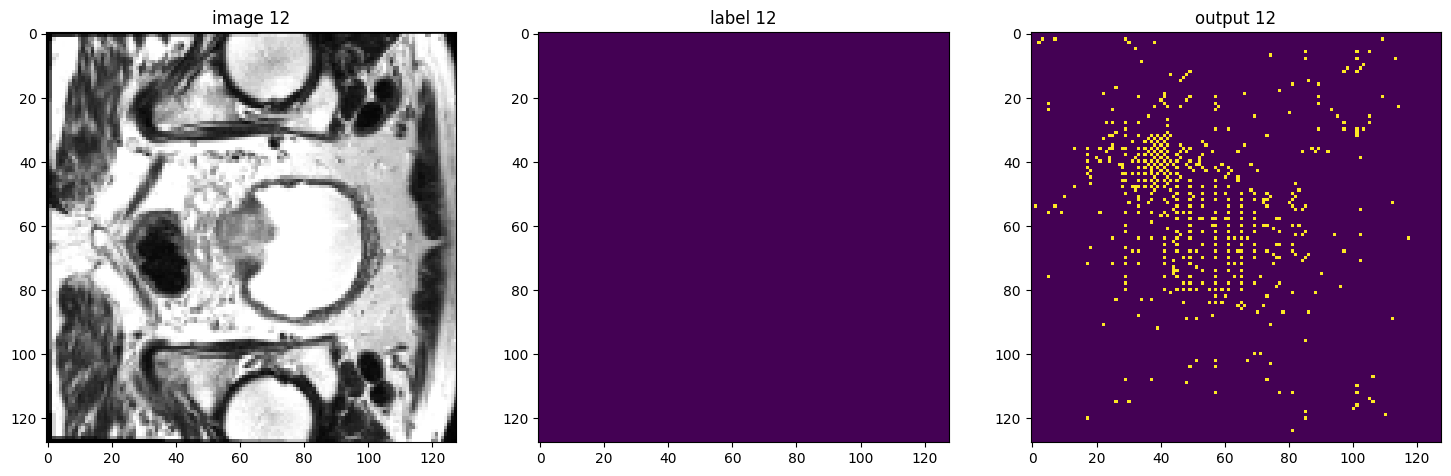

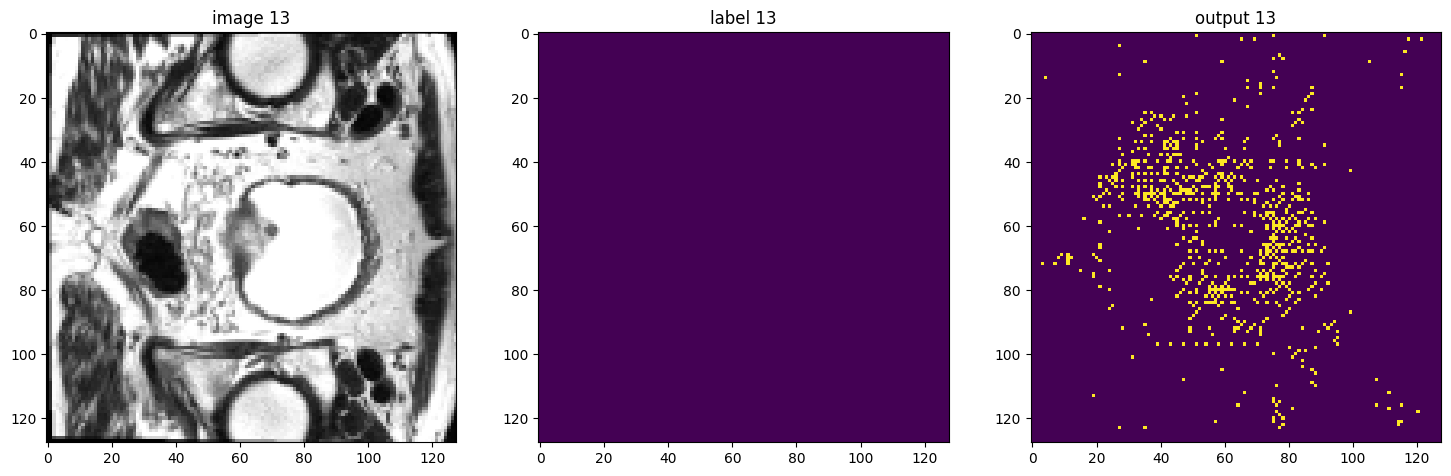

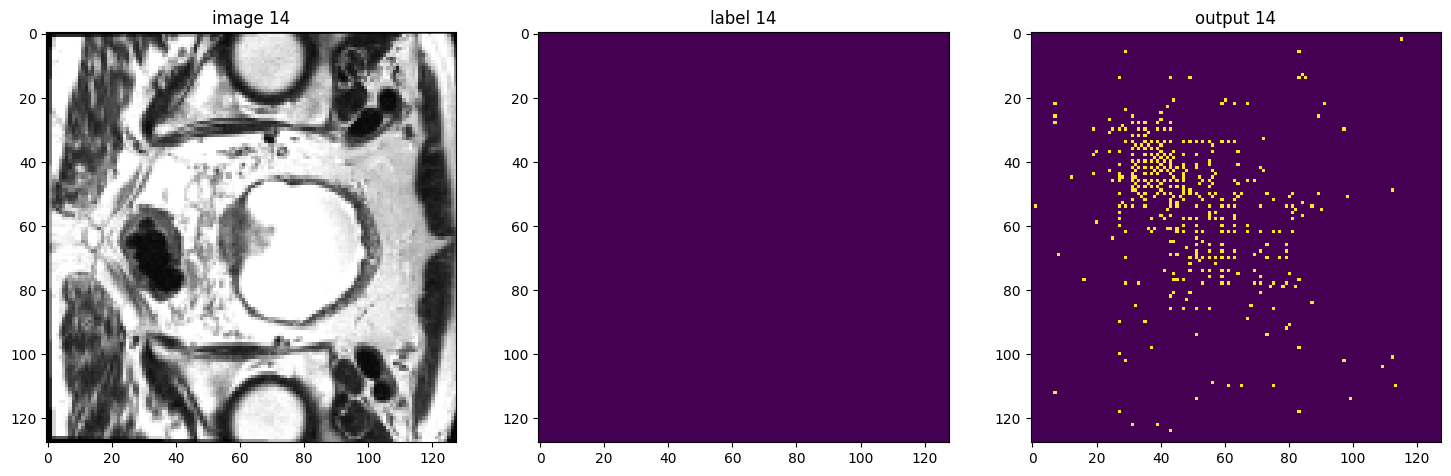

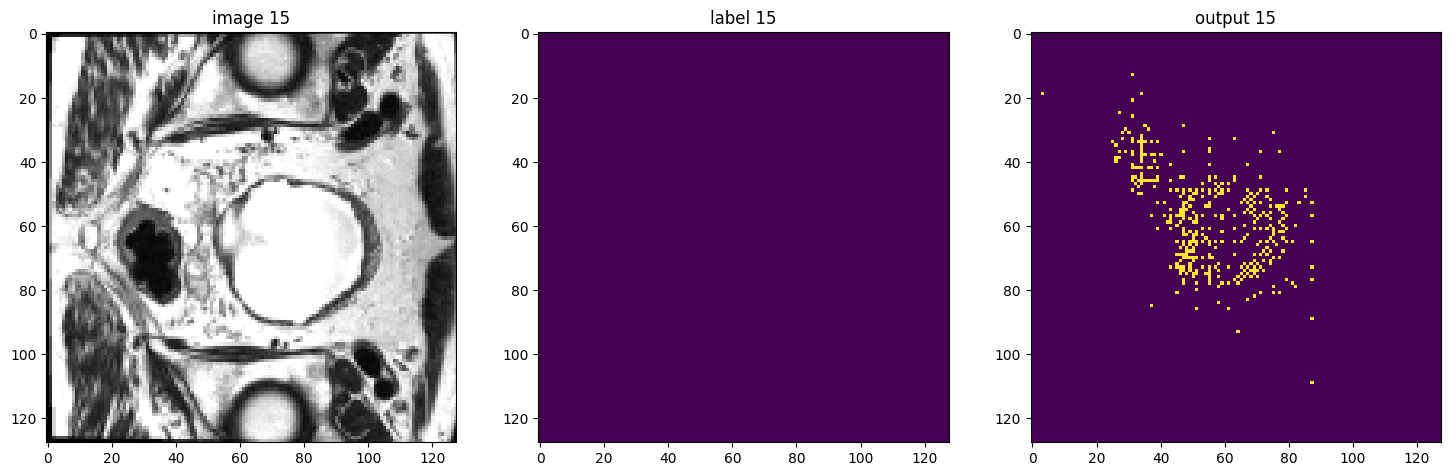

In [ ]:
sw_batch_size = 4
roi_size = spatial_size
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['seg']
    print(t_volume.shape)
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.8
        
    for i in range(spatial_size[2]):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 0, :, :, i])
        plt.show()